In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import glob
from sklearn.preprocessing import scale, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA

gc.enable()

In [ ]:
data_path = '/content/drive/My Drive/Mineria de datos/datasets/'

training_path = data_path + 'training_set/'
track_features_path = data_path + 'track_features/'

training_logs = sorted(glob.glob(training_path + "log_*.csv"))
track_logs = sorted(glob.glob(track_features_path + 'tf_*.csv'))

In [ ]:
training_logs

In [ ]:
SESSIONS = pd.concat([pd.read_csv(path) for path in training_logs[::6]], ignore_index=True)

In [ ]:
TRACKS = pd.concat([pd.read_csv(path) for path in track_logs], ignore_index=True)

In [ ]:
#TRACKS.info()
SESSIONS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69110728 entries, 0 to 69110727
Data columns (total 21 columns):
session_id                         object
session_position                   int64
session_length                     int64
track_id_clean                     object
skip_1                             bool
skip_2                             bool
skip_3                             bool
not_skipped                        bool
context_switch                     int64
no_pause_before_play               int64
short_pause_before_play            int64
long_pause_before_play             int64
hist_user_behavior_n_seekfwd       int64
hist_user_behavior_n_seekback      int64
hist_user_behavior_is_shuffle      bool
hour_of_day                        int64
date                               object
premium                            bool
context_type                       object
hist_user_behavior_reason_start    object
hist_user_behavior_reason_end      object
dtypes: bool(6), int64(9

###Exploratory Data Analysis 

##### number tracks and skip proportion vs hour of the day

In [ ]:
s = SESSIONS.loc[:, ['track_id_clean', 'hour_of_day', 'skip_1', 'skip_2']]
s['skip'] = s[ 'skip_1'] | s['skip_2']

t = TRACKS.loc[:,'track_id']

to_plot = s.merge(t, how='left', left_on='track_id_clean', right_on='track_id')

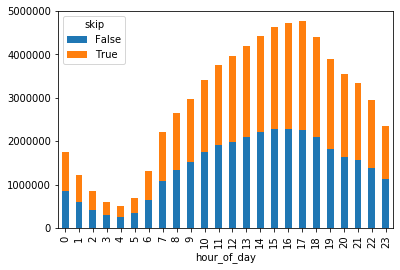

In [ ]:
to_plot = to_plot[['skip', 'hour_of_day']].groupby("hour_of_day")['skip'].value_counts().unstack()
to_plot.plot(kind='bar', stacked='True')

##### number of tracks and skip proportion vs premium user or not

In [ ]:
s = SESSIONS.loc[:, ['track_id_clean', 'premium', 'skip_1', 'skip_2']]
s['skip'] = s[ 'skip_1'] | s['skip_2']

t = TRACKS.loc[:,'track_id']

to_plot = s.merge(t, how='left', left_on='track_id_clean', right_on='track_id')

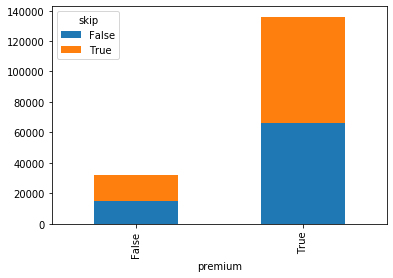

In [ ]:
to_plot = to_plot[['skip', 'premium']].groupby("premium")['skip'].value_counts().unstack()
to_plot.plot(kind='bar', stacked='True')

##### popularity in United states vs skip or not

In [ ]:
s = SESSIONS.loc[:, ['track_id_clean', 'skip_1', 'skip_2']]
t = TRACKS.loc[:,['track_id', 'us_popularity_estimate']]
s['skip'] = s[ 'skip_1'] | s['skip_2']

to_plot = s.merge(t, how='left', left_on='track_id_clean', right_on='track_id')

In [ ]:
bins = 4
to_plot_ = to_plot[['skip', 'us_popularity_estimate']]
to_plot_ = to_plot_.groupby(
                            pd.cut(to_plot['us_popularity_estimate'], bins)
                            )['skip'].value_counts().unstack()


In [ ]:
to_plot_.reset_index(inplace=True)

In [ ]:
to_plot_.columns = ['us_popularity_estimate', 'False', 'True']

In [ ]:
to_plot_

,us_popularity_estimate,False,True
0,"(89.99, 92.5]",129160,154598
1,"(92.5, 95.0]",234010,259968
2,"(95.0, 97.5]",587139,641442
3,"(97.5, 100.0]",32880223,34224188


In [ ]:
#to_plot_.plot(kind='bar', stacked='True')

to_plot_['FalseP'] = to_plot_['False']*100/(to_plot_['False'] + to_plot_['True'])
to_plot_['TrueP'] = to_plot_['True']*100/(to_plot_['False'] + to_plot_['True'])

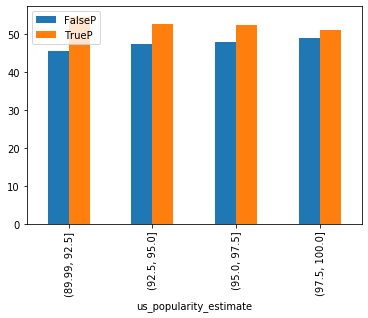

In [ ]:
to_plot_.plot(kind='bar', x='us_popularity_estimate', y=['FalseP', 'TrueP'])

In [ ]:
t['us_popularity_estimate'].describe()

count    3.706388e+06
mean     9.557394e+01
std      2.735566e+00
min      9.000000e+01
25%      9.338183e+01
50%      9.575417e+01
75%      9.792122e+01
max      1.000000e+02
Name: us_popularity_estimate, dtype: float64

### Data Transformation

In [ ]:
SESSIONS['hour_of_day'].value_counts()

In [ ]:
# <------------- All Columns -------------------->
print(SESSIONS.columns)
print(TRACKS.columns)

Index(['session_id', 'session_position', 'session_length', 'track_id_clean',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end'],
      dtype='object')
Index(['track_id', 'duration', 'release_year', 'us_popularity_estimate',
       'acousticness', 'beat_strength', 'bounciness', 'danceability',
       'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mechanism', 'mode', 'organism', 'speechiness',
       'tempo', 'time_signature', 'valence', 'acoustic_vector_0',
       'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
       'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6',


In [ ]:
SESSIONS[[
        'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_is_shuffle', 'premium',
]] = SESSIONS[[
        'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_is_shuffle', 'premium',
]].astype('bool')

In [ ]:
for column in tf:
    print('{} nan: {}'.format(column, TRACKS[column].isna().sum()))

In [ ]:
print(' hist_user_behavior_n_seekfwd: ', SESSIONS['hist_user_behavior_n_seekfwd'].describe())
print('\n hist_user_behavior_n_seekback: ', SESSIONS['hist_user_behavior_n_seekback'].describe())
print('\n hour_of_day: ', SESSIONS['hour_of_day'].describe())
#print(SESSIONS['date'])
print('\n track_duration: ', TRACKS['duration'].describe())
print('\n us_popularity_estimate: ', TRACKS['us_popularity_estimate'].describe())
print('')
#print(TRACKS['release_year'].max())

sf = [
      'hist_user_behavior_n_seekfwd',
      'hist_user_behavior_n_seekback',
      'hour_of_day'
]

tf = [
      'acousticness', 'beat_strength', 'bounciness', 'danceability',
      'dyn_range_mean', 'energy', 'flatness', 'instrumentalness',
      'liveness', 'loudness', 'mechanism', 'organism', 'speechiness',
      'tempo', 'time_signature', 'valence', 'acoustic_vector_0',
      'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
      'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6',
      'acoustic_vector_7'
]

#for column in tf:
#    print('\n {}: {}'.format(column, TRACKS[column].describe()))


### Scaling the data

In [ ]:
scaler = MinMaxScaler()
SESSIONS[sf] = scaler.fit_transform(SESSIONS[sf])

scaler1 = MinMaxScaler()
TRACKS[['us_popularity_estimate', 'duration']] = scaler1.fit_transform(TRACKS[['us_popularity_estimate', 'duration']])

TRACKS[tf] = scale(TRACKS[tf])

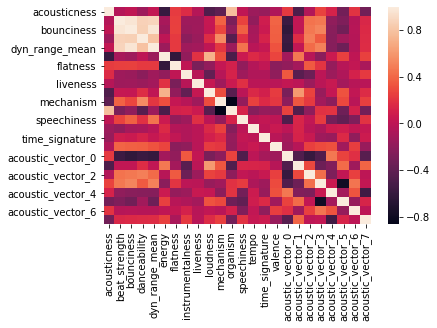

In [ ]:
# -------------- cov 1 ---------------->
sb.heatmap(TRACKS[tf].corr())

### PCA
#####  Dimensionality reduction, elimination of redundant information on the characteristics of the tracks.

In [ ]:
# -------------- cov with PCA ---------------->
cov_matrix = PCA(n_components=len(tf))
cov_matrix.fit(TRACKS[tf])

PCA(copy=True, iterated_power='auto', n_components=24, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
explained_variances = cov_matrix.explained_variance_ratio_ 
cumulative_sum_variance =  np.cumsum(np.round(explained_variances, decimals=3)*100)

explained_variances

array([0.24442667, 0.18600758, 0.09655602, 0.08548136, 0.06618965,
       0.05858761, 0.04296683, 0.03759932, 0.03389438, 0.02974401,
       0.0223206 , 0.01973779, 0.01726765, 0.01571257, 0.01287889,
       0.00979297, 0.00678388, 0.00479409, 0.0041796 , 0.00216025,
       0.0016914 , 0.00054429, 0.00038936, 0.00029324])

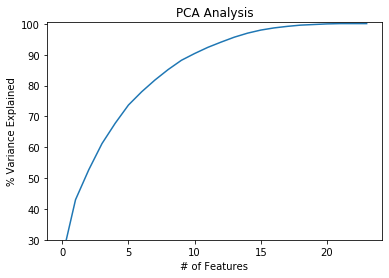

In [ ]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)

plt.plot(cumulative_sum_variance)

In [ ]:
# <---- choosing n_components = 15 according to the above plot---->

pca = PCA(n_components=15)
tracks_principal_components = pca.fit_transform(TRACKS[tf])

tracks_principal_components_columns = ['pca{}'.format(i) for i in range(1, 16)]

tracks_principal_components = pd.DataFrame(data=tracks_principal_components, columns=tracks_principal_components_columns)

In [ ]:
tracks_principal_components.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15
0,1.980661,2.042419,3.633714,1.171361,1.225977,-1.724177,-1.709409,-0.546300,-1.370812,0.722735,1.140706,-0.327298,0.040497,-0.556215,0.999458
1,2.762396,7.197336,1.036390,0.270932,-0.258450,-0.091282,-0.646028,0.972722,0.586373,1.507584,0.415178,-0.618402,-0.758506,-0.434146,1.255146
2,1.990690,4.887415,1.564925,-0.229546,-0.543582,-0.855259,-0.059818,-0.882650,-0.829106,0.596269,1.252157,-1.164615,-0.114176,-0.711354,1.285718
3,2.470690,1.706321,2.245449,0.202201,0.490345,-1.583418,-0.413953,-0.779756,0.476124,0.758265,0.591786,-0.039168,0.438197,-0.913943,-0.216129
4,3.579376,1.585461,1.690147,0.452921,-0.352037,-1.674693,0.617457,-0.176477,-0.756518,0.219534,-0.388643,-0.543037,-0.914363,-1.090117,0.567772


In [ ]:
TRACKS.drop(tf, axis=1, inplace=True)
TRACKS.drop('release_year', axis=1, inplace=True)
TRACKS = pd.concat([TRACKS, tracks_principal_components], axis=1)

In [ ]:
TRACKS.head()

,track_id,duration,release_year,us_popularity_estimate,key,mode,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,0.045338,1950,0.997537,0,major,1.980661,2.042419,3.633714,1.171361,1.225977,-1.724177,-1.709409,-0.546300,-1.370812,0.722735,1.140706,-0.327298,0.040497,-0.556215,0.999458
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,0.089706,1950,0.996937,0,major,2.762396,7.197336,1.036390,0.270932,-0.258450,-0.091282,-0.646028,0.972722,0.586373,1.507584,0.415178,-0.618402,-0.758506,-0.434146,1.255146
2,t_0614ecd3-a7d5-40a1-816e-156d5872a467,0.074429,1951,0.960180,0,minor,1.990690,4.887415,1.564925,-0.229546,-0.543582,-0.855259,-0.059818,-0.882650,-0.829106,0.596269,1.252157,-1.164615,-0.114176,-0.711354,1.285718
3,t_070a63a0-744a-434e-9913-a97b02926a29,0.082712,1951,0.966439,0,major,2.470690,1.706321,2.245449,0.202201,0.490345,-1.583418,-0.413953,-0.779756,0.476124,0.758265,0.591786,-0.039168,0.438197,-0.913943,-0.216129
4,t_d6990e17-9c31-4b01-8559-47d9ce476df1,0.193194,1951,0.999175,0,major,3.579376,1.585461,1.690147,0.452921,-0.352037,-1.674693,0.617457,-0.176477,-0.756518,0.219534,-0.388643,-0.543037,-0.914363,-1.090117,0.567772


In [ ]:
DATA_ALL.columns

Index(['session_id', 'session_position', 'session_length', 'track_id_clean',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end',
       'track_id', 'duration', 'release_year', 'us_popularity_estimate', 'key',
       'mode', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8',
       'pca9', 'pca10', 'pca11', 'pca12', 'pca13', 'pca14', 'pca15'],
      dtype='object')

### Feature Selection.
##### based on feature importance in tree-based model

In [ ]:
DATA_ALL = SESSIONS.merge(TRACKS, how='left', left_on='track_id_clean', right_on='track_id')
DATA_ALL.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end,track_id,duration,us_popularity_estimate,key,mode,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,False,False,False,False,0.0,0.0,True,0.695652,2018-07-15,True,editorial_playlist,trackdone,trackdone,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0.085367,0.996808,1,major,-0.570044,-0.787242,-1.369181,0.852735,-0.704108,0.877114,-0.505513,-1.187501,2.595559,0.482088,-0.772328,-0.245728,0.403473,-0.452478,0.253172
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,False,True,False,False,0.0,0.0,True,0.695652,2018-07-15,True,editorial_playlist,trackdone,trackdone,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,0.117641,0.989654,7,minor,-3.329582,-0.935558,-0.868606,-1.120948,0.110533,-0.096350,-0.263702,0.212795,0.256695,0.331129,-0.324225,-0.035689,-0.553105,0.057755,0.670013
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,False,True,False,False,0.0,0.0,True,0.695652,2018-07-15,True,editorial_playlist,trackdone,trackdone,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,0.114495,0.999998,10,major,-1.299882,-0.670074,-1.110214,-0.899403,-0.608872,0.381571,-0.874851,-0.106542,0.130381,-0.026527,0.039851,0.023879,-0.471107,-1.113689,0.189449
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,False,True,False,False,0.0,0.0,True,0.695652,2018-07-15,True,editorial_playlist,trackdone,trackdone,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,0.079541,0.999503,1,major,-2.450322,1.392950,-1.027900,0.086441,-0.531163,-0.462958,0.482903,0.405798,-0.778909,-2.038564,0.317594,0.547405,-0.388728,-0.878507,0.173293
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,False,True,False,False,0.0,0.0,True,0.695652,2018-07-15,True,editorial_playlist,trackdone,trackdone,t_64f3743c-f624-46bb-a579-0f3f9a07a123,0.102706,0.999850,8,major,-4.059998,-0.329366,-0.448063,0.242055,0.580559,-0.695379,-1.001501,0.367603,-0.350955,0.131281,-0.091321,-0.287910,0.031935,-0.089666,0.014107


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()

In [ ]:
X = DATA_ALL[['context_switch','no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'premium',
       'duration', 'release_year', 'us_popularity_estimate',
       'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8',
       'pca9', 'pca10', 'pca11', 'pca12', 'pca13', 'pca14', 'pca15'
]]

y = DATA_ALL['skip_1'] | DATA_ALL['skip_2']

In [ ]:
DATA_ALL['premium'].value_counts()

True     136053
False     31827
Name: premium, dtype: int64

In [ ]:
model.fit(X,y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [ ]:
print(model.feature_importances_)

[0.0086979  0.01280021 0.00628682 0.00540329 0.01133034 0.01446102
 0.00802966 0.24471137 0.00720398 0.03881301 0.03508059 0.03860122
 0.03820329 0.03791278 0.0378597  0.03844076 0.03753177 0.03746833
 0.0382384  0.03650818 0.03762426 0.03830476 0.03813737 0.03801822
 0.03820711 0.03818902 0.03793661]


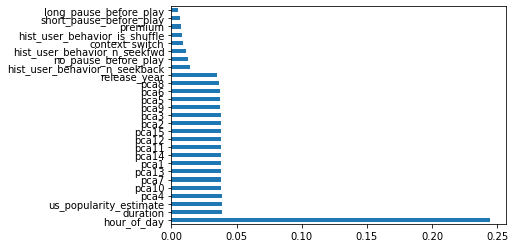

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')
plt.show()

### Getting the data ready for train

In [ ]:
DATA_ALL['skip'] = DATA_ALL['skip_1'] | DATA_ALL['skip_2']
DATA_ALL.drop(['skip_1', 'skip_2', 'skip_3', 'not_skipped', 'date', 'key'], axis=1, inplace=True)

In [ ]:
DATA_ALL.columns

Index(['session_id', 'session_position', 'session_length', 'track_id_clean',
       'context_switch', 'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end',
       'track_id', 'duration', 'us_popularity_estimate', 'mode', 'pca1',
       'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10',
       'pca11', 'pca12', 'pca13', 'pca14', 'pca15', 'skip'],
      dtype='object')

In [ ]:
def transformc(df, features_column_names):
    columns_names = []
    for i in range(3):
        temp = []
        for column in features_column_names:
            temp.append(column + str(i+1))
        columns_names.append(temp)


    dfx = df[features_column_names].copy()

    df1 = pd.concat(
        [
         dfx.iloc[[0]], 
         dfx.iloc[[0]], 
         dfx
        ],
        ignore_index=True
    )
    df1.columns = columns_names[0]

    df2 = pd.concat(
        [
         dfx.iloc[[0]], 
         dfx, 
         dfx.iloc[[dfx.shape[0]-1]]
        ],
        ignore_index=True
    )
    df2.columns = columns_names[1]
    
    df3 = pd.concat(
        [
         dfx,
         dfx.iloc[[dfx.shape[0]-1]], 
         dfx.iloc[[dfx.shape[0]-1]]
        ],
        ignore_index=True
    )
    df3.columns = columns_names[2]


    out_df = pd.concat([df1, df2, df3], axis=1)
    out_df.drop(0, inplace=True)
    out_df.drop(out_df.shape[0], inplace=True)
    out_df.reset_index(inplace=True, drop=True)

    out_df[['session_id', 'session_position', 'session_length']] = df[['session_id', 'session_position', 'session_length']]
    out_df['skip'] = df['skip']

    return out_df


In [ ]:
features_column_names = [
       'context_switch', 'no_pause_before_play',
       'short_pause_before_play', 'long_pause_before_play',
       'hist_user_behavior_n_seekfwd', 'hist_user_behavior_n_seekback',
       'hist_user_behavior_is_shuffle', 'hour_of_day', 'premium',
       'context_type', 'hist_user_behavior_reason_start',
       'hist_user_behavior_reason_end', 'duration',
       'us_popularity_estimate', 'mode', 'pca1', 'pca2', 'pca3', 'pca4',
       'pca5', 'pca6', 'pca7', 'pca8', 'pca9', 'pca10', 'pca11', 'pca12',
       'pca13', 'pca14', 'pca15']

In [ ]:
out = transformc(DATA_ALL, features_column_names)

In [ ]:
out.head()

,context_switch1,no_pause_before_play1,short_pause_before_play1,long_pause_before_play1,hist_user_behavior_n_seekfwd1,hist_user_behavior_n_seekback1,hist_user_behavior_is_shuffle1,hour_of_day1,premium1,context_type1,hist_user_behavior_reason_start1,hist_user_behavior_reason_end1,duration1,us_popularity_estimate1,mode1,pca11,pca21,pca31,pca41,pca51,pca61,pca71,pca81,pca91,pca101,pca111,pca121,pca131,pca141,pca151,context_switch2,no_pause_before_play2,short_pause_before_play2,long_pause_before_play2,hist_user_behavior_n_seekfwd2,hist_user_behavior_n_seekback2,hist_user_behavior_is_shuffle2,hour_of_day2,premium2,context_type2,...,pca102,pca112,pca122,pca132,pca142,pca152,context_switch3,no_pause_before_play3,short_pause_before_play3,long_pause_before_play3,hist_user_behavior_n_seekfwd3,hist_user_behavior_n_seekback3,hist_user_behavior_is_shuffle3,hour_of_day3,premium3,context_type3,hist_user_behavior_reason_start3,hist_user_behavior_reason_end3,duration3,us_popularity_estimate3,mode3,pca13,pca23,pca33,pca43,pca53,pca63,pca73,pca83,pca93,pca103,pca113,pca123,pca133,pca143,pca153,session_id,session_position,session_length,skip
0,False,False,False,False,0.0,0.0,True,0.695652,True,editorial_playlist,trackdone,trackdone,0.085367,0.996808,major,-0.570044,-0.787242,-1.369181,0.852735,-0.704108,0.877114,-0.505513,-1.187501,2.595559,0.482088,-0.772328,-0.245728,0.403473,-0.452478,0.253172,False,False,False,False,0.0,0.0,True,0.695652,True,editorial_playlist,...,0.482088,-0.772328,-0.245728,0.403473,-0.452478,0.253172,False,True,False,False,0.0,0.0,True,0.695652,True,editorial_playlist,trackdone,trackdone,0.117641,0.989654,minor,-3.329582,-0.935558,-0.868606,-1.120948,0.110533,-0.096350,-0.263702,0.212795,0.256695,0.331129,-0.324225,-0.035689,-0.553105,0.057755,0.670013,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,False
1,False,False,False,False,0.0,0.0,True,0.695652,True,editorial_playlist,trackdone,trackdone,0.085367,0.996808,major,-0.570044,-0.787242,-1.369181,0.852735,-0.704108,0.877114,-0.505513,-1.187501,2.595559,0.482088,-0.772328,-0.245728,0.403473,-0.452478,0.253172,False,True,False,False,0.0,0.0,True,0.695652,True,editorial_playlist,...,0.331129,-0.324225,-0.035689,-0.553105,0.057755,0.670013,False,True,False,False,0.0,0.0,True,0.695652,True,editorial_playlist,trackdone,trackdone,0.114495,0.999998,major,-1.299882,-0.670074,-1.110214,-0.899403,-0.608872,0.381571,-0.874851,-0.106542,0.130381,-0.026527,0.039851,0.023879,-0.471107,-1.113689,0.189449,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,False
2,False,True,False,False,0.0,0.0,True,0.695652,True,editorial_playlist,trackdone,trackdone,0.117641,0.989654,minor,-3.329582,-0.935558,-0.868606,-1.120948,0.110533,-0.096350,-0.263702,0.212795,0.256695,0.331129,-0.324225,-0.035689,-0.553105,0.057755,0.670013,False,True,False,False,0.0,0.0,True,0.695652,True,editorial_playlist,...,-0.026527,0.039851,0.023879,-0.471107,-1.113689,0.189449,False,True,False,False,0.0,0.0,True,0.695652,True,editorial_playlist,trackdone,trackdone,0.079541,0.999503,major,-2.450322,1.392950,-1.027900,0.086441,-0.531163,-0.462958,0.482903,0.405798,-0.778909,-2.038564,0.317594,0.547405,-0.388728,-0.878507,0.173293,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,False
3,False,True,False,False,0.0,0.0,True,0.695652,True,editorial_playlist,trackdone,trackdone,0.114495,0.999998,major,-1.299882,-0.670074,-1.110214,-0.899403,-0.608872,0.381571,-0.874851,-0.106542,0.130381,-0.026527,0.039851,0.023879,-0.471107,-1.113689,0.189449,False,True,False,False,0.0,0.0,True,0.695652,True,editorial_playlist,...,-2.038564,0.317594,0.547405,-0.388728,-0.878507,0.173293,False,True,False,False,0.0,0.0,True,0.695652,True,editorial_playlist,trackdone,trackdone,0.102706,0.999850,major,-4.059998,-0.329366,-0.448063,0.242055,0.580559,-0.695379,-1.001501,0.367603,-0.350955,0.131281,-0.091321,-0.287910,0.031935,-0.089666,0.014107,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,False
4,False,True,False,False,0.0,0.0,True,0.695652,True,editorial_playlist,t

In [ ]:
out.to_pickle('/content/drive/My Drive/Mineria de datos/datasets/preprocessed/training_MINI.pkl')